In [1]:
# Setup sys.path to import from src/
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [23]:
# Spark session
from pyspark.sql import SparkSession, functions as F

# Import custom functions
from src.preprocessing import load_data, clean_data, feature_engineer, assemble_features
from src.save_outputs import save_predictions, save_feature_importances, save_model_metadata
from src.model import pick_best_model_from_grid, evaluate_model, manual_grid_search_rf, manual_grid_search_dt, manual_grid_search_gbt, manual_grid_search_lr, manual_grid_search_nb
from src.mongo_export import create_mongo_database, get_collection

In [ ]:
spark = SparkSession.builder \
    .appName("Ecommerce Behavior Exploration") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


In [4]:
# Load raw dataset
file_path = "../data/scaledData-2019-Nov.csv"
raw_df = load_data(file_path, spark)

# Quick look at raw data
raw_df.show(5)
raw_df.printSchema()


+--------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|2019-11-17 12:57:...|      view|   1005239|2053013555631882655|electronics.smart...| xiaomi| 262.3|517220397|294a6e27-97e1-4f6...|
|2019-11-20 09:05:...|      view|   1004655|2053013555631882655|electronics.smart...|samsung|744.17|561605578|22682045-26c7-4e7...|
|2019-11-17 03:40:...|      view|   1801653|2053013554415534427|electronics.video.tv|    tcl|539.47|530939266|d90cf77a-cba9-4fe...|
|2019-11-14 09:29:...|      view|   1004250|2053013555631882655|electronics.smart...|  apple|778.36|571366119|b321c1d5-7de3-440...|
|2019-11-20 20:16:...|      view|   7102014|2053013555464110485|furniture.be

In [5]:
# Clean the dataset
clean_df = clean_data(raw_df)

# Quick check after cleaning
clean_df.show(5)


+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|2019-11-17 07:57:11|      view|   1005239|2053013555631882655|electronics.smart...| xiaomi| 262.3|517220397|294a6e27-97e1-4f6...|
|2019-11-20 04:05:49|      view|   1004655|2053013555631882655|electronics.smart...|samsung|744.17|561605578|22682045-26c7-4e7...|
|2019-11-16 22:40:32|      view|   1801653|2053013554415534427|electronics.video.tv|    tcl|539.47|530939266|d90cf77a-cba9-4fe...|
|2019-11-14 04:29:48|      view|   1004250|2053013555631882655|electronics.smart...|  apple|778.36|571366119|b321c1d5-7de3-440...|
|2019-11-20 15:16:22|      view|   7102014|2053013555464110485|furniture.bedroom...

In [6]:
# Create new features if needed
feature_df = feature_engineer(clean_df)

# Quick preview
feature_df.show(5)


+--------------------+---------+-------------+-------------+-------------------+-------------------+------------------+----------------+
|        user_session|num_views|num_cart_adds|num_purchases|      session_start|        session_end|         avg_price|session_duration|
+--------------------+---------+-------------+-------------+-------------------+-------------------+------------------+----------------+
|e7b1d62a-2052-417...|        1|            0|            0|2019-11-25 23:17:45|2019-11-25 23:17:45|             20.32|               0|
|347a49d4-879c-40b...|        2|            0|            0|2019-11-16 06:55:01|2019-11-16 07:08:11|318.21000000000004|             790|
|a8c4169c-f7c5-4ac...|        1|            0|            0|2019-11-18 08:10:00|2019-11-18 08:10:00|            167.06|               0|
|5ea7b452-8a45-47a...|        3|            0|            0|2019-11-25 11:59:49|2019-11-25 12:19:57| 39.85333333333333|            1208|
|55f2520f-972e-4c2...|        1|         

In [7]:
labels = clean_df.groupBy("user_session").agg(
    (F.max(F.when(F.col("event_type") == "purchase", 1).otherwise(0))).alias("label")
)

final_df = feature_df.join(labels, on="user_session", how="left").fillna(0)


In [8]:
# Feature columns you want to use
feature_cols = ['num_views', 'num_cart_adds', 'session_duration', 'avg_price']

# Assemble features
final_df = assemble_features(final_df, feature_cols)

In [9]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

In [10]:
manual_grid_search_rf(train_df, test_df)

🚀 Starting Manual Random Forest grid search with model saves...
🔵 Training: numTrees=50, maxDepth=10, maxBins=32
🔹 AUC: 0.9997
✅ Predictions saved: ../output/rf/rf_50_10_32\predictions.csv
✅ Feature importances saved: ../output/rf/rf_50_10_32\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_50_10_32\metadata.json
🔵 Training: numTrees=200, maxDepth=20, maxBins=64
🔹 AUC: 0.9994
✅ Predictions saved: ../output/rf/rf_200_20_64\predictions.csv
✅ Feature importances saved: ../output/rf/rf_200_20_64\feature_importances.csv
✅ Model metadata saved: ../output/rf/rf_200_20_64\metadata.json

✅ Manual Grid Search Complete! All outputs saved.


In [ ]:
manual_grid_search_lr(train_df, test_df)


In [ ]:
manual_grid_search_dt(train_df, test_df)

In [ ]:

manual_grid_search_nb(train_df, test_df)

In [12]:
manual_grid_search_gbt(train_df, test_df)

🚀 Starting Manual GBTClassifier grid search...
🔵 Training: maxIter=50, maxDepth=5, maxBins=32
🔹 AUC: 0.9997
✅ Predictions saved: ../output/gbt/gbt_50_5_32\predictions.csv
✅ Feature importances saved: ../output/gbt/gbt_50_5_32\feature_importances.csv
✅ Model metadata saved: ../output/gbt/gbt_50_5_32\metadata.json
🔵 Training: maxIter=100, maxDepth=10, maxBins=64
🔹 AUC: 0.9997
✅ Predictions saved: ../output/gbt/gbt_100_10_64\predictions.csv
✅ Feature importances saved: ../output/gbt/gbt_100_10_64\feature_importances.csv
✅ Model metadata saved: ../output/gbt/gbt_100_10_64\metadata.json

✅ Manual Grid Search Complete for GBTClassifier!


In [ ]:
# for random forest model

base_rf_dir = "../output/rf/"
base_lr_dir = "../output/lr/"
base_dt_dir = "../output/dt/"
base_nb_dir = "../output/nb/"
base_gbt_dir = "../output/gbt/"

dic = {"model":"", "params": "", "AUC": 0 }

results = []

print("RF: ")
results_csv_path_rf = os.path.join(base_rf_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_rf, base_rf_dir).split(','))

print("LR: ")
results_csv_path_lr = os.path.join(base_lr_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_lr, base_lr_dir).split(','))

print("DT: ")
results_csv_path_dt = os.path.join(base_dt_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_dt, base_dt_dir).split(','))

print("NB: ")
results_csv_path_nb = os.path.join(base_nb_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_nb, base_nb_dir).split(','))

print("GBT: ")
results_csv_path_gbt = os.path.join(base_gbt_dir, "grid_search_results.csv")
results.append(pick_best_model_from_grid(results_csv_path_gbt, base_gbt_dir).split(','))

for r in results:
    if float(r[1]) >= dic["AUC"]:
        dic["model"] = r[2]
        dic["params"] = r[0][:-2]
        dic["AUC"] = float(r[1])
print(dic)

RF: 
🏆 Best Model: 50_10_32_0 with AUC: 0.9997
GBT: 
🏆 Best Model: 50_5_32_0 with AUC: 0.9997
{'model': 'gbt', 'params': '50_5_32', 'AUC': 0.9997404411164906}


In [43]:
# Save a list of best hyperparameters or feature names
import json

with open("../output/best_params.json", "w") as f:
    json.dump(dic, f)


In [41]:
# Load predictions CSV (adjust path if needed)
model, params = dic["model"], dic["params"]
predictions_path = f"../output/{model}/{model}_{params}/predictions.csv"
df_predictions = pd.read_csv(predictions_path)

df_predictions.head()


,user_session,num_views,num_cart_adds,label,prediction,probability,session_duration,avg_price
0,00021579-e80a-4553-923a-9acb510718d6,1,0,0,0.0,"[0.9784791144416625,0.021520885558337532]",0,139.63
1,0008663a-bb23-48a6-a352-d72f923382d6,1,0,0,0.0,"[0.9784791144416629,0.02152088555833709]",0,57.66
2,000a2c76-7339-4f92-9873-8fe0ce279422,1,0,0,0.0,"[0.9784791144416625,0.021520885558337532]",0,159.57
3,000cd6bd-883b-4655-bc00-9b9c57349dcb,1,0,0,0.0,"[0.9784791144416622,0.021520885558337755]",0,46.08
4,00169aa7-2ed6-4ecf-a502-2fa3e4cbe986,1,0,0,0.0,"[0.9784791144416625,0.021520885558337532]",0,32.18


In [42]:
create_mongo_database(df_predictions.to_dict(orient='records'))

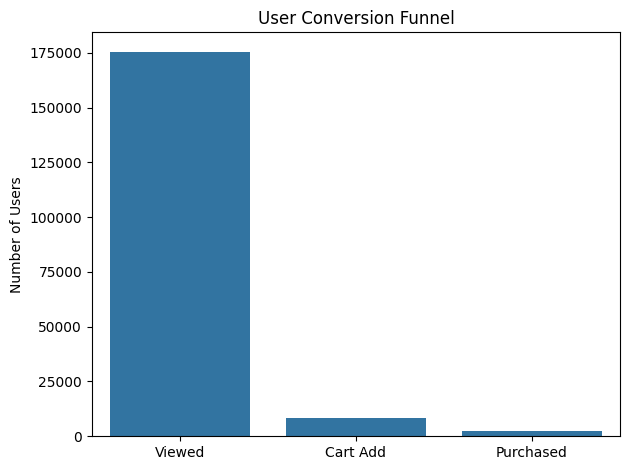

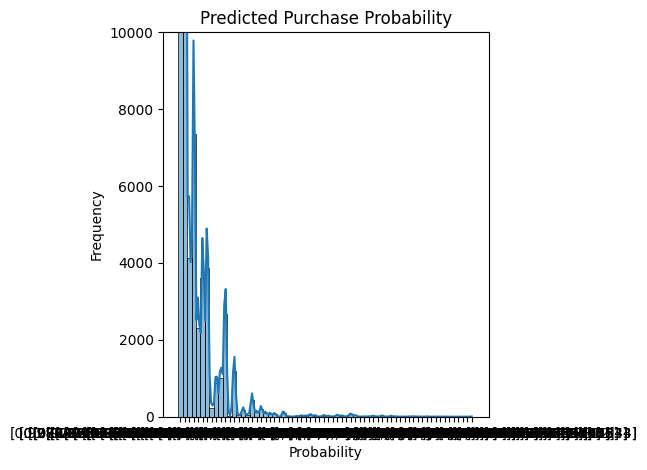

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

output_dir = "../output/figures"
os.makedirs(output_dir, exist_ok=True)

collection = get_collection()
# Fetch from MongoDB
df_mongo = pd.DataFrame(list(collection.find()))

# Drop MongoDB's default _id field
df_mongo = df_mongo.drop(columns=["_id"], errors='ignore')

# --- Visualization 1: Conversion Funnel ---
funnel = {
    "Viewed": df_mongo.shape[0],
    "Cart Add": df_mongo[df_mongo["num_cart_adds"] > 0].shape[0],
    "Purchased": df_mongo[df_mongo["label"] == 1].shape[0]
}
sns.barplot(x=list(funnel.keys()), y=list(funnel.values()))
plt.title("User Conversion Funnel")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "conversion_funnel.png"), dpi=300)
plt.show()

# --- Visualization 2: Predicted Purchase Probabilities ---
if 'probability' in df_mongo.columns:
    sns.histplot(df_mongo['probability'], bins=30, kde=True)
    plt.title("Predicted Purchase Probability")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.ylim(0, 10000)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "purchase_probability.png"), dpi=300)
    plt.show()


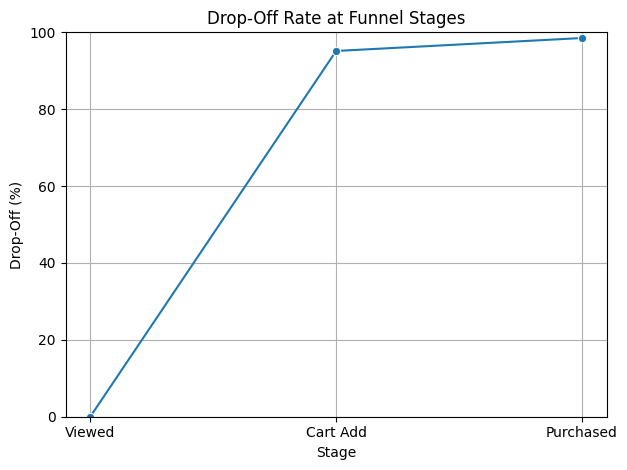

In [38]:
funnel_df = pd.DataFrame({
    "Stage": ["Viewed", "Cart Add", "Purchased"],
    "Users": [funnel["Viewed"], funnel["Cart Add"], funnel["Purchased"]]
})
funnel_df["Dropoff %"] = 100 * (1 - funnel_df["Users"] / funnel_df["Users"].iloc[0])

sns.lineplot(data=funnel_df, x="Stage", y="Dropoff %", marker="o")
plt.title("Drop-Off Rate at Funnel Stages")
plt.ylabel("Drop-Off (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.savefig("../output/figures/dropoff_rate.png")
plt.show()


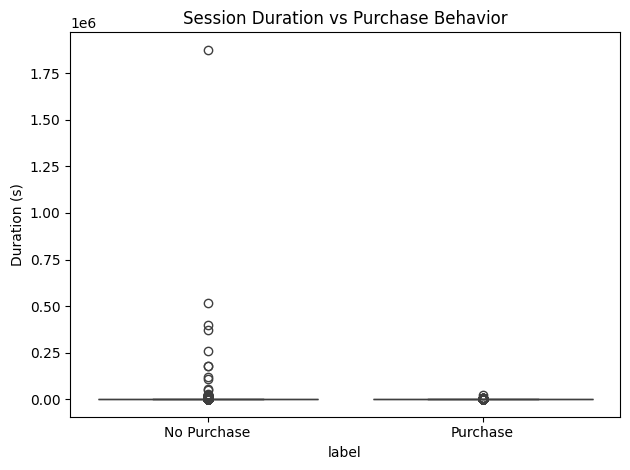

In [26]:
sns.boxplot(data=df_mongo, x="label", y="session_duration")
plt.xticks([0, 1], ["No Purchase", "Purchase"])
plt.title("Session Duration vs Purchase Behavior")
plt.ylabel("Duration (s)")
plt.tight_layout()
plt.savefig("../output/figures/session_duration_vs_purchase.png")
plt.show()


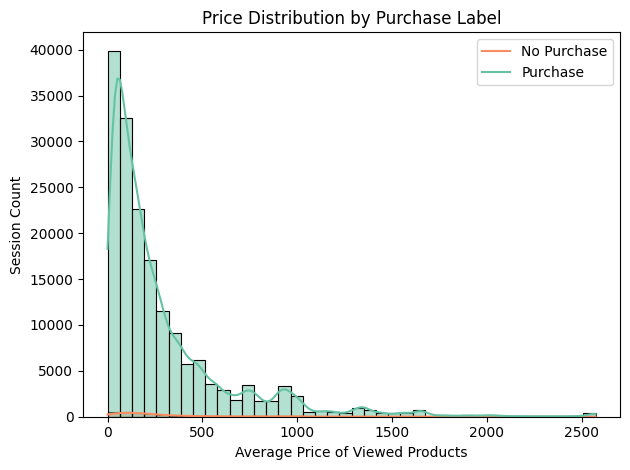

In [27]:
sns.histplot(data=df_mongo, x="avg_price", hue="label", bins=40, kde=True, palette="Set2")
plt.title("Price Distribution by Purchase Label")
plt.xlabel("Average Price of Viewed Products")
plt.ylabel("Session Count")
plt.legend(["No Purchase", "Purchase"])
plt.tight_layout()
plt.savefig("../output/figures/price_vs_purchase.png")
plt.show()